# Calculate projection effects in redmapper

In [1]:
#import everything
import sys, os
from astropy.io import fits # per leggere fits file
import numpy as np
from scipy.optimize import curve_fit,minimize
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## see https://matplotlib.org/users/customizing.html to customize
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')
matplotlib.rc('figure',figsize=( 9.6, 6.8))
matplotlib.rc('xtick',labelsize=20)
matplotlib.rc('ytick',labelsize=20)
matplotlib.rc('legend',fontsize='x-large')
matplotlib.rc('xtick',direction='in')
matplotlib.rc('xtick',labelsize=24)
matplotlib.rc('xtick.major',size=7)
matplotlib.rc('xtick.minor',size=4)
matplotlib.rc('xtick.major',width=1.25)
matplotlib.rc('xtick.minor',width=1.25)
matplotlib.rc('ytick',direction='in')
matplotlib.rc('ytick',labelsize=24)
matplotlib.rc('ytick.major',size=7)
matplotlib.rc('ytick.minor',size=4)
matplotlib.rc('ytick.major',width=1.25)
matplotlib.rc('ytick.minor',width=1.25)
matplotlib.rc('patch',edgecolor='k' )
matplotlib.rc('legend',markerscale=1.5)
matplotlib.rc('errorbar',capsize = 3)
matplotlib.rc('axes',labelsize='x-large')
matplotlib.rc('axes',linewidth=1.25)

In [3]:
#Load DES Y3 lambda(z) data or whatever you want to use
datapath = "chto_y3_gold_2.2.1_wide_sofcol_run2_lz_run_runpos.fit"
hdu_list = fits.open(datapath)

In [4]:
# Here I'm using DES Y3 data, you should assign to each array your values
id_cluster=hdu_list[1].data['MEM_MATCH_ID'] # ID of the cluster
lambda_in = hdu_list[1].data['LAMBDA_IN'] # The TRUE richness of the cluster
z_in=hdu_list[1].data['Z_LAMBDA_IN'] # The TRUE redshift of the cluster
lambda_arrays = hdu_list[1].data['LAMBDA_CHISQS'] # Measured richness as function of redshift, i.e. lambda(z)
z_domain = np.arange(0.1,0.950,0.005) # Grid over which lambda(z) is measured
print z_domain.shape
print lambda_arrays.shape
del hdu_list

(170,)
(38316, 170)


Now we define a comparison function, as well as a model for $\lambda(z)$.

In [66]:
# Delta_z sets the redshift range around z_in used to fit the data.
# The smaller the value the better the fit to the peak of lambda(z)
# Increase the value to fit also the tail of lambda(z)
# Delta_z=0.1 is a good compromise to correctly fit clear l.o.s. systems and moderately disturbed ones
Delta_z=0.1

# Delta_lambda sets the lowever values of lambda(z) (realtive to the maximum lambda(z) values) used in the fit
# A value of 20% is recommended in real data to avoid fitting the often disturbed tails of the lambda(z) distribution
Delta_lambda=0.2

# You can check the effects of these parameters in the example below

#Lambda(z) model function, basically a parabola
def lambda_model(z, sigmaz, z_peak, lambda_peak):
    l_mod=lambda_peak - (sigmaz*1.0e4)*(z-z_peak)**2.
    l_mod[l_mod<0.]=0.
    return l_mod

#The comparison function used to fit the model
def comparison(params, z_domain, lambda_array,zin):
    z_peak, sigmaz, lambda_peak = params #Pull out the parameters
    #Some priors
    if any(params < 0.0): return np.inf
    if z_peak > 4.0: return np.inf #Way too high redshift
    if lambda_peak > 1000: return np.inf #Way too big
    if np.abs(z_peak-zin ) > Delta_z: return np.inf #Too far away from the true redshift
    
    lam_model = lambda_model(z_domain, sigmaz, z_peak, lambda_peak)
    X = (lambda_array - lam_model)**2
    z_cond =(z_domain < zin+Delta_z)* (z_domain > zin-Delta_z)
    max_lambda_in_z_cond= max(lambda_array[z_cond]) # this is to be sure that it considers the max lambda in the relevant z-range
    indices = (lambda_array > max_lambda_in_z_cond*Delta_lambda) * z_cond
    return sum(X[indices])

Try this procedure on a single cluster

In [67]:
ii=9 # ID of the cluster you want to check
x0 = [z_in[ii], 1., lambda_in[ii]]

result = minimize(comparison, x0=x0, args=(z_domain, lambda_arrays[ii],z_in[ii]), method='Nelder-Mead')
zbest, szbest, lambest = result['x']
print result

 final_simplex: (array([[  0.32980942,   1.57135429, 147.3768387 ],
       [  0.32980944,   1.57134975, 147.37674505],
       [  0.32980951,   1.57135546, 147.37683123],
       [  0.32980947,   1.57135084, 147.3768518 ]]), array([2157.12860849, 2157.12860856, 2157.12860874, 2157.12860887]))
           fun: 2157.128608487432
       message: 'Optimization terminated successfully.'
          nfev: 156
           nit: 84
        status: 0
       success: True
             x: array([  0.32980942,   1.57135429, 147.3768387 ])


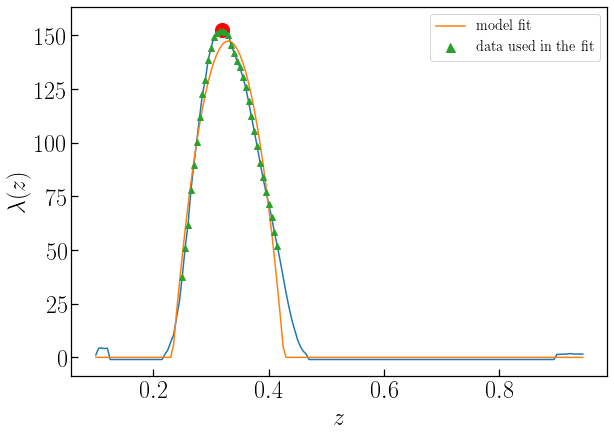

In [68]:
def make_plot(z_peak, sigmaz, lambda_peak, z_in, lambda_in, z_domain, lambda_array, save=False, index=None):
    plt.plot(z_domain, lambda_array)
    plt.scatter(z_in, lambda_in, marker='o',s=200,color='r')
    plt.plot(z_domain, lambda_model(z_domain, sigmaz, z_peak, lambda_peak),label='model fit')
    plt.ylabel("$\\lambda(z)$", fontsize=24)
    plt.xlabel("$z$", fontsize=24)
    z_cond =(z_domain < z_in+Delta_z)* (z_domain > z_in-Delta_z)
    max_lambda_in_z_cond= max(lambda_array[z_cond]) # this is to be sure that it consider the max in the relevant z-range
    indices = (lambda_array > max_lambda_in_z_cond*Delta_lambda) * z_cond
    plt.plot(z_domain[indices], lambda_array[indices],'^',label='data used in the fit')
    plt.legend()
    return

make_plot(zbest, szbest, lambest, z_in[ii], lambda_in[ii], z_domain, lambda_arrays[ii], index=ii)


Great. Let's proceed with every other cluster and save the outputs.

In [69]:
N = len(lambda_arrays)
sz_all = np.zeros((N)) #sigmaz for all clusters
zp_all = np.zeros((N)) #z_peak for all clusters
lp_all = np.zeros((N)) #lambda_peak for all clusters
chis = np.zeros((N)) #to estiamte the goodness of the fit (it is not exactly the chisq value)

for i in xrange(0,N):
    x0 = [z_in[i], 1., lambda_in[i]] # Mine per creare y1a1_gold_1.0.3._v2_
    result = minimize(comparison, x0=x0, args=(z_domain, lambda_arrays[i],z_in[i]), method='Nelder-Mead')
    zp_all[i], sz_all[i], lp_all[i] = result['x']

    # for the goodness of fit just use the data point actaully used to fit
    z_cond =(z_domain < z_in[i]+Delta_z)* (z_domain > z_in[i]-Delta_z)
    max_lambda_in_z_cond= max((lambda_arrays[i])[z_cond]) # this is to be sure that it consider the max in the relevant z-range
    indices = (lambda_arrays[i] > max_lambda_in_z_cond*Delta_lambda) * z_cond
    tosum=np.abs(lambda_model(z_domain[indices], sz_all[i], zp_all[i], lp_all[i])-(lambda_arrays[i])[indices])/(lambda_arrays[i])[indices]
    chis[i]=np.sum(tosum)/len(tosum)
    if i%500==0: print "At cluster %d"%i

At cluster 0
At cluster 500
At cluster 1000
At cluster 1500
At cluster 2000
At cluster 2500
At cluster 3000
At cluster 3500
At cluster 4000
At cluster 4500
At cluster 5000
At cluster 5500
At cluster 6000
At cluster 6500
At cluster 7000
At cluster 7500
At cluster 8000
At cluster 8500
At cluster 9000
At cluster 9500
At cluster 10000
At cluster 10500
At cluster 11000
At cluster 11500
At cluster 12000
At cluster 12500
At cluster 13000
At cluster 13500
At cluster 14000
At cluster 14500
At cluster 15000
At cluster 15500
At cluster 16000
At cluster 16500
At cluster 17000
At cluster 17500
At cluster 18000
At cluster 18500
At cluster 19000
At cluster 19500
At cluster 20000
At cluster 20500
At cluster 21000
At cluster 21500
At cluster 22000
At cluster 22500
At cluster 23000
At cluster 23500
At cluster 24000
At cluster 24500
At cluster 25000
At cluster 25500
At cluster 26000
At cluster 26500
At cluster 27000
At cluster 27500
At cluster 28000
At cluster 28500
At cluster 29000
At cluster 29500
At c

In [73]:
# Define sig_z_kernel according to Eq. 9 of the Projection effect paper (https://arxiv.org/pdf/1807.07072.pdf)
# With this transformation sig_z_kernel represents the width of the parabola used to fit lambda(z)  
sig_z_kernel=(sz_all/lp_all)**(-0.5)/100. 

done


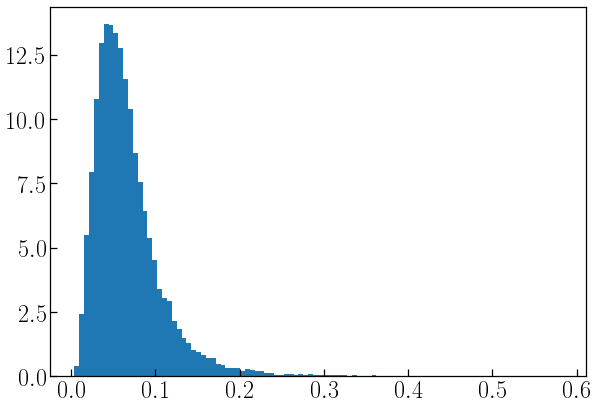

In [70]:
# Plot the chis distribution
# You can use chis to assess the goodness of the fit, e.g. see below
plt.hist(chis,bins=100,density=True)
print 'done'

127


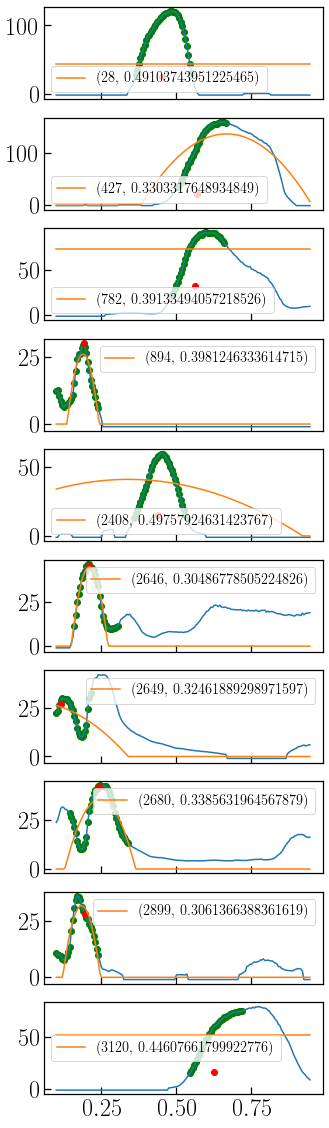

In [80]:
# Example of a systems with bad chis
cond=(chis>0.3)
idx=np.arange(len(z_in))
idx_to_keep=idx[cond]

print len(idx_to_keep)

f, ax = plt.subplots(min(10,len(idx_to_keep)), 1, sharex=True, figsize=(5,20))

for i,idx in enumerate(idx_to_keep[:min(10,len(idx_to_keep))]):
    z_cond =(z_domain < z_in[idx]+0.1)* (z_domain > z_in[idx]-0.1)
    max_lambda_in_z_cond= max((lambda_arrays[idx])[z_cond]) # this is to be sure that it consider the max in the relevant z-range
    indices = (lambda_arrays[idx] > max_lambda_in_z_cond*0.2) * z_cond
    ax[i].plot(z_domain[indices], (lambda_arrays[idx])[indices],'go')
    ax[i].plot(z_domain, lambda_arrays[idx])
    ax[i].plot(z_in[idx],lambda_in[idx],'ro') # quello che matcha con redMaPPer usato per il fit
    ax[i].plot(z_domain,lambda_model(z_domain, sz_all[idx], zp_all[idx], lp_all[idx]),label=(idx,chis[idx]))
    ax[i].legend()


Text(0,0.5,'$\\sigma_z$')

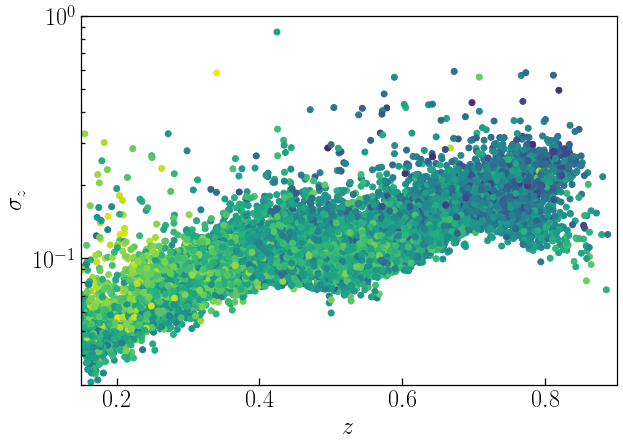

In [82]:
plt.scatter(zp_all, sig_z_kernel,c=np.log(chis))
plt.yscale('log',nonposy='clip')
plt.xlim(0.15,0.9)
plt.ylim(0.03,1.0)
plt.xlabel("$z$",fontsize=24)
plt.ylabel("$\sigma_z$",fontsize=24)